## Pre-processing MAST rhythmic data

### This is an auxiliary notebook which targets at the preparation of data towards the automatic assessment analysis. It requires the data downloaded using the _DownloadDataFromMASTDataset_ notebook.

### Along this notebook we will extract onset times information from both references and performances, scale performances according to their respective references and convert the onset times to a binary representation which might be more suitable to the application of distance measures

### Loading Essentia's necessary tools

In [205]:
from essentia.standard import *
from essentia import Pool, array

import os
import numpy as np
import math
import matplotlib.pyplot as plt


SAMPLE_RATE = 44100
WINDOW_SIZE = 1024
HOP_SIZE = 512

ONSET_WINDOW_SIZE = 0.1 # 100ms

WINDOWING_METHOD = 'hann'
ONSET_DETECTION_METHOD = 'complex'

def _load_file_as_monophonic_waveform(file_path):
    fs = SAMPLE_RATE

    x = MonoLoader(filename = file_path, sampleRate = fs)()
    return x/np.max(np.abs(x))

def _extract_onset_vectors(waveform):
    od_hfc = OnsetDetection(method=ONSET_DETECTION_METHOD)
    w = Windowing(type = WINDOWING_METHOD)
    fft = FFT()
    c2p = CartesianToPolar()
    onsets = Onsets()

    pool = Pool()
    for frame in FrameGenerator(waveform, frameSize = WINDOW_SIZE, hopSize = HOP_SIZE):
        mag, phase, = c2p(fft(w(frame)))
        pool.add('features', od_hfc(mag, phase))

    onsets = onsets(array([pool['features']]),[1])
    return onsets

### Extracting onset times and writing output to auxiliar file. After executing the below one can check the onset times in a file inside the data folders

In [206]:
def extract_onsets(base_dir, list_files, output_file):
    with open(list_files, 'r') as listfiles:
        with open(output_file, 'w') as output:
            for audio_file in listfiles.readlines():
                audio_file = audio_file.strip()
                audio_file_full_path = '%s%s' % (base_dir, audio_file)

                w = _load_file_as_monophonic_waveform(audio_file_full_path)
                onsets = _extract_onset_vectors(w)

                output.write('%s\n' % " ".join(list(str(x) for x in onsets)))

DATA_FOLDER = "../data/"

# extracting onset times for performances
base_dir_performances = os.path.join(DATA_FOLDER, 'Only Performances/') 
list_files_performances = os.path.join(DATA_FOLDER, 'Only Performances/listperformances')
output_file_performances = os.path.join(DATA_FOLDER, 'Only Performances/MAST Onsets [Performances]')

extract_onsets(base_dir_performances, list_files_performances, output_file_performances)

# extracting onset times for references
base_dir_references = os.path.join(DATA_FOLDER, 'Only References/')
list_files_references = os.path.join(DATA_FOLDER, 'Only References/listreferences')
output_file_references = os.path.join(DATA_FOLDER, 'Only References/MAST Onsets [References]')

extract_onsets(base_dir_references, list_files_references, output_file_references)

### Rescaling performances onsets times according to their reference lengths and converting them into a binary representation (a 1 in the i-eth position means the presence of a beat in the i-eth time window). After executing the below one can check the binary representation of the onset times in a file inside the data folders

In [207]:
def rescale_and_make_bins(performances_file, references_file, window_size=ONSET_WINDOW_SIZE):
    with open(performances_file, 'r') as perf_onsets_file:
        with open(references_file, 'r') as ref_onsets_file:
            perfs_onsets = perf_onsets_file.readlines()
            refs_onsets = ref_onsets_file.readlines()
            with open('%s [BINS]' % performances_file, 'w') as performances_file_bin,\
                 open('%s [BINS]' % references_file, 'w') as references_file_bin,\
                 open('%s [SCALING DATA]' % performances_file, 'w') as performances_scaling_file,\
                 open('%s [SCALING DATA]' % references_file, 'w') as references_scaling_file:
                for i in range(len(perfs_onsets)):
                    perf_onsets = [ float(x) for x in perfs_onsets[i].strip().split(" ") ]
                    perf_first_onset = perf_onsets[0]
                    perf_last_onset = perf_onsets[-1]
                    
                    ref_onsets = [ float(x) for x in refs_onsets[i].strip().split(" ") ]
                    ref_first_onset = ref_onsets[0]
                    ref_last_onset = ref_onsets[-1]

                    # setting onset boundaries from first to last onsets
                    perf_onsets = [ x - perf_onsets[0] for x in perf_onsets ]                   
                    ref_onsets = [ x - ref_onsets[0] for x in ref_onsets ]
                    

                    # re-scaling performance to match reference tempo
                    perf_inner_duration = perf_onsets[-1] - perf_onsets[0]
                    ref_inner_duration = ref_onsets[-1] - ref_onsets[0]
                    time_rescaling_factor = ((perf_inner_duration - ref_inner_duration) / perf_inner_duration)
                    
                    # saving scaling info for plotting purposes
                    # first onset / last onset / inner duration / scaling factor (only for performances)
                    performances_scaling_file.write('%f %f %f %f\n' % (perf_first_onset,perf_last_onset, perf_inner_duration, time_rescaling_factor))
                    references_scaling_file.write('%f %f %f\n' % (ref_first_onset,ref_last_onset, ref_inner_duration))

                    rescaled_perf_onsets = [adjust_onset_by_rate(onset, time_rescaling_factor) for onset in perf_onsets]

                    performance_onset_bins = make_bins(rescaled_perf_onsets, window_size)
                    performances_file_bin.write('%s\n' % " ".join([str(x) for x in performance_onset_bins]))

                    references_onset_bins = make_bins(ref_onsets, window_size)
                    references_file_bin.write('%s\n' % " ".join([str(x) for x in references_onset_bins]))


def make_bins(onset_times, windows_size):
    total_length = onset_times[-1] - onset_times[0]
    n_bins = math.ceil(total_length/windows_size)
    bins = []

    for i in range(int(n_bins)):
        for onset_time in onset_times:
            if windows_size*i <= onset_time <= windows_size*(i+1):
                bins.append(1)
                break
        else:
            bins.append(0)

    return bins

def adjust_onset_by_rate(onset, time_rescaling_factor):
    return onset - (onset * time_rescaling_factor)

# running functions over data
rescale_and_make_bins(os.path.join(DATA_FOLDER, 'Only Performances/MAST Onsets [Performances]'),
                         os.path.join(DATA_FOLDER, 'Only References/MAST Onsets [References]'))


### Plotting waveforms, Essentia onsets and binary onsets for validation purposes

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:37: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


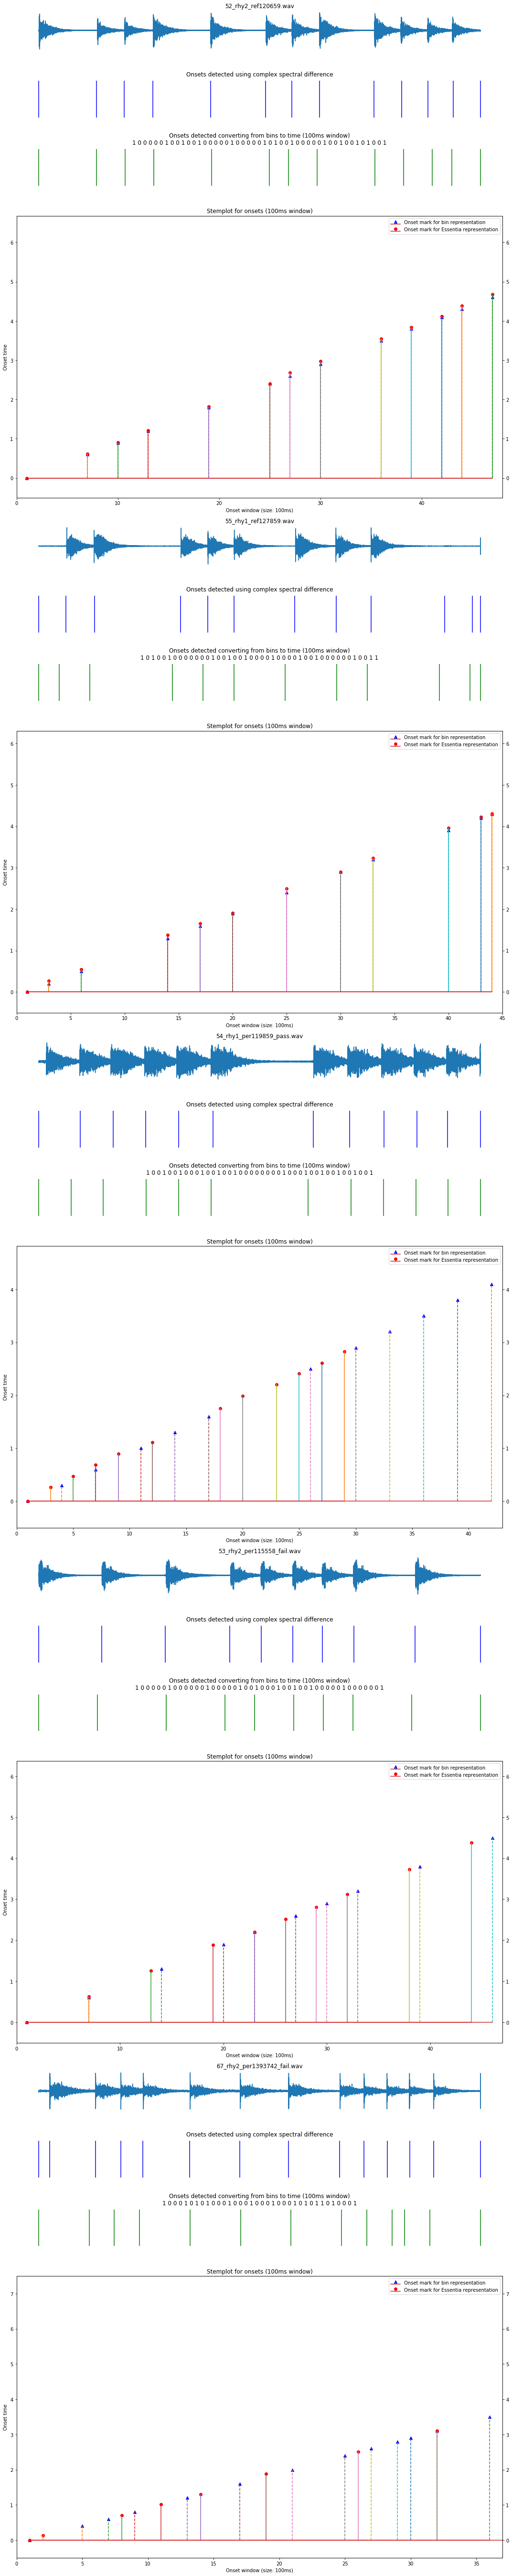

In [216]:
audio_samples = ['Only References/52_rhy2_ref120659.wav', 'Only References/55_rhy1_ref127859.wav',
                'Only Performances/54_rhy1_per119859_pass.wav', 'Only Performances/53_rhy2_per115558_fail.wav',
                'Only Performances/67_rhy2_per1393742_fail.wav']

# gets the audio index of an our auxiliar files (previously stored data)
def get_audio_index(file, performance_type):
    file_path = os.path.join(DATA_FOLDER, 'Only %ss' % performance_type.capitalize(), 'list%ss' % performance_type)
    with open(file_path, 'r') as list_files:
        files = [x.strip() for x in list_files.readlines()]
        return files.index(file)
    
# gets the auxiliar info (previously stored data) given a file and the info file format    
def get_info(file, performance_type, info_file_format):   
    index = get_audio_index(file, performance_type)
    file_path = os.path.join(DATA_FOLDER, 'Only %ss' % performance_type.capitalize(), info_file_format.format(performance_type.capitalize()))
    
    with open(file_path, 'r') as scaling_infos:
        scaling_info = scaling_infos.readlines()[index]
        return [float(x) for x in scaling_info.split()]
    
       

f, axarr = plt.subplots(len(audio_samples) * 4,1,figsize=(15, len(audio_samples)*15), gridspec_kw = {'height_ratios':len(audio_samples) *[1,1,1,7]})
idx = 0

for audio in audio_samples:
    file_name = audio.split('/')[1]
    
    ## Plotting weveform ###
    
    w = _load_file_as_monophonic_waveform(os.path.join(DATA_FOLDER, audio))
    
    # filtering waveform to range from first to last onsets
    scaling_info = get_info(file_name, 'reference' if 'ref' in file_name else 'performance', 'MAST Onsets [{}s] [SCALING DATA]')
    
    # scaling_info[0] is the first onset. scaling_info[1] is the last one
    w = w[scaling_info[0] * SAMPLE_RATE : scaling_info[1] * SAMPLE_RATE]
    
    t=np.arange(len(w))   

    axarr[idx].plot(t,w)
    axarr[idx].axis('off')
    axarr[idx].set_title(file_name);

    essentia_onsets = get_info(file_name, 'reference' if 'ref' in file_name else 'performance', 'MAST Onsets [{}s]')
    # scaling essentia onsets so the first onset is in moment 0
    essentia_onsets = [x - essentia_onsets[0] for x in essentia_onsets]
    
    idx+=1   
    
    ## Plotting onsets computed by essentia ###
    
    axarr[idx].set_title('Onsets detected using complex spectral difference');
    axarr[idx].axis('off')
    axarr[idx].vlines(essentia_onsets, -1, 1, color='b')   

    ## Plotting onsets reconverted from bins
    onset_bins = get_info(file_name, 'reference' if 'ref' in file_name else 'performance', 'MAST Onsets [{}s] [BINS]')

    # Converting from bins to time according to window size (100ms)
    bins_to_onsets = []
    for i in range(len(onset_bins)):
        # if there's a beat on that window
        if onset_bins[i]:
            bins_to_onsets.append(i * ONSET_WINDOW_SIZE)  
            
    idx+=1
    
    axarr[idx].set_title('Onsets detected converting from bins to time (100ms window)\n%s' % " ".join(str(int(i)) for i in onset_bins));
    axarr[idx].axis('off')
    axarr[idx].vlines(bins_to_onsets, -1, 1, color='g')    
    
    idx+=1

    ## Plotting stems from both essentia and bins onsets ###
    
    bins_stems = []
    
    # converting from onset bins to bins boundaries
    # (e.g) a 1 in a index #10 means a beat in the window #10
    # (boundaries: 0,9s - 1s). window size is 100ms
    for i in range(len(onset_bins)):
        if onset_bins[i]:
            bins_stems.append((onset_bins[i] * (i+1)))   

    axarr[idx].set_title('Stemplot for onsets (100ms window)')    
    axarr[idx].set_xlim([0,len(onset_bins) + 1])
    # setting y limit with some extra buffer (time is scaled for performances)
    axarr[idx].set_ylim([-0.5,scaling_info[2] + 2])
    axarr[idx].set_xlabel("Onset window (size: 100ms)")
    axarr[idx].set_ylabel("Onset time")
    # Plotting bins stems
    plot_one = axarr[idx].stem(bins_stems, bins_to_onsets, '--', markerfmt='b^',label='Onset mark for bin representation')
    
    # Plotting essentia stems (overlapped)
    # (e.g ) an onset in moment 0.95s means
    # a beat with boundaries [0,9s - 1s] which 
    # translates to window/stem 10
    essentia_stems = [int(essentia_onset / ONSET_WINDOW_SIZE) + 1 for essentia_onset in essentia_onsets]
    
   
    overlapped = axarr[idx].twinx()    
    overlapped.set_xlim([0,len(onset_bins) + 1])
    # setting y limit with some extra buffer (time is scaled for performances)
    overlapped.set_ylim([-0.5,scaling_info[2] + 2])
    
    plot_two = overlapped.stem(essentia_stems, essentia_onsets, '-',markerfmt='ro',label='Onset mark for Essentia representation')
    
    # added these three lines
    plots = [plot_one, plot_two]
    labs = [plot.get_label() for plot in plots]
    axarr[idx].legend(plots, labs, loc=0)
    
    idx+=1
    
f.tight_layout()

